In [352]:
import pandas as pd

# Cek struktur dataset
df = pd.read_csv("/Users/farrel01/Documents/MesinBelajar - Project/balanced_dataset.csv")

# Tampilkan nama kolom dan contoh isi
print("Kolom yang tersedia:\n", df.columns.tolist())
print("\nContoh 3 baris data:\n", df.head(3))

Kolom yang tersedia:
 ['No', 'answer', '1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE', 'Text_Clean', 'filtered_text', 'token', 'tokens_stemmed', 'Process_Data', 'synthetic_aug']

Contoh 3 baris data:
    No                                             answer  1-FR  2-GI  3-PI  \
0   1  Halo Rizal,Radang tenggorokan umunya disebabka...     1     0     1   
1   2  Halo Hellas,Cacar air merupakan suatu penyakit...     1     0     1   
2   3  Halo Rory.......Terimakasih atas pertanyaan An...     1     0     1   

   4-DM  5-EDTRB  6-RE                                         Text_Clean  \
0     1        1     0  halo rizal radang tenggorokan umunya disebabka...   
1     1        1     0  halo hellas cacar air merupakan suatu penyakit...   
2     1        1     0  halo rory terimakasih atas pertanyaan anda per...   

                                       filtered_text  \
0  halo rizal radang tenggorokan umunya disebabka...   
1  halo hellas cacar air penyakit disebabkan viru...   
2  hal

In [354]:
# Command: Import library dasar
import pandas as pd
import numpy as np
import re
import string

# Text processing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

# Load dataset
df = pd.read_csv("/Users/farrel01/Documents/MesinBelajar - Project/balanced_dataset.csv")

# Cek kolom teks dan label
text_col = "Process_Data"
label_cols = ['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE']

# Pastikan tidak ada NaN
df = df.dropna(subset=[text_col])

# Pisahkan teks dan label
X = df[text_col]
y = df[label_cols]

In [360]:
# (Opsional) cek distribusi label
print("Distribusi tiap label:\n", y.sum())

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("✅ TF-IDF shape train:", X_train_tfidf.shape)
print("✅ TF-IDF shape test:", X_test_tfidf.shape)

Distribusi tiap label:
 1-FR       3110
2-GI       1482
3-PI       3110
4-DM       2860
5-EDTRB    3105
6-RE       1473
dtype: int64
✅ TF-IDF shape train: (2488, 8000)
✅ TF-IDF shape test: (622, 8000)


In [362]:
# ==============================================================
#  Step C: FEATURE ENGINEERING — FIXED VERSION
# ==============================================================

In [364]:
import gensim
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix, issparse
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from nltk.tokenize import word_tokenize
from gensim.models.fasttext import load_facebook_vectors
from skmultilearn.model_selection import IterativeStratification

In [366]:
# --------------------------------------------------------------
# 1. Load FastText Bahasa Indonesia (rekomendasi)
# --------------------------------------------------------------

print("⏳ Loading FastText Indonesian model...")
fasttext_model = gensim.models.FastText.load_fasttext_format(
    "/Users/farrel01/Documents/fasttext/cc.id.300.bin"
)
print("✅ FastText Indo loaded successfully")

⏳ Loading FastText Indonesian model...


/var/folders/jr/bnpd2zjx6dg94lplg1mppz100000gn/T/ipykernel_17686/3017416114.py:6: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_model = gensim.models.FastText.load_fasttext_format(


✅ FastText Indo loaded successfully


In [367]:
# --------------------------------------------------------------
# 2. Function: embedding kalimat
# --------------------------------------------------------------

def get_sentence_vector(text):
    tokens = word_tokenize(str(text).lower())
    vectors = []

    for w in tokens:
        if w in fasttext_model.wv:
            vectors.append(fasttext_model.wv[w])

    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300, dtype=np.float32)

In [368]:

# --------------------------------------------------------------
# 3. Buat embedding train-test
# --------------------------------------------------------------

print("🔧 Making FastText embeddings...")

X_train_embed = np.vstack(X_train.apply(get_sentence_vector))
X_test_embed  = np.vstack(X_test.apply(get_sentence_vector))

print("Shapes:", X_train_embed.shape, X_test_embed.shape)

🔧 Making FastText embeddings...
Shapes: (2488, 300) (622, 300)


In [369]:
# --------------------------------------------------------------
# 4. Scaling embedding
# --------------------------------------------------------------

scaler = StandardScaler()
X_train_embed_scaled = scaler.fit_transform(X_train_embed)
X_test_embed_scaled  = scaler.transform(X_test_embed)

In [370]:
# --------------------------------------------------------------
# 5. Gabung TF-IDF + Embedding
# --------------------------------------------------------------

# Convert sparse TF-IDF into dense? → NO (to save memory)
# Convert embedding to sparse? → YES (efficient)

X_train_embed_sparse = csr_matrix(X_train_embed_scaled)
X_test_embed_sparse  = csr_matrix(X_test_embed_scaled)

X_train_combined = hstack([X_train_tfidf, X_train_embed_sparse])
X_test_combined  = hstack([X_test_tfidf, X_test_embed_sparse])

print("Final combined shape (train):", X_train_combined.shape)

Final combined shape (train): (2488, 8300)


In [371]:
# ==============================================================
# STEP 6 — MULTI-LABEL BALANCING (FINAL VERSION — FIXED)
# Menggunakan Iterative Oversampling (metode paling benar)
# ==============================================================
    
print("⚖️ Balancing multi-label dataset using Iterative Oversampling...")

# ======= FIXED MULTILABEL OVERSAMPLING (PASTE & REPLACE) =======

import numpy as np
import pandas as pd
from scipy.sparse import vstack, issparse

def iterative_oversample_sparse_fixed(X, Y, desired_size, random_state=42):
    """
    Oversample multilabel dataset while keeping label combinations intact.
    Duplicate full samples then select remainder prioritizing rare labels.
    """
    np.random.seed(random_state)
    n = X.shape[0]

    # if target smaller or equal → no oversampling
    if desired_size <= n:
        return X, Y.copy()

    # full repeats
    repeats = desired_size // n
    remainder = desired_size - repeats * n

    # repeat X & Y
    X_rep = vstack([X] * repeats) if issparse(X) else np.vstack([X] * repeats)
    Y_rep = pd.concat([Y] * repeats, ignore_index=True)

    # pick remainder based on minority label weighting
    label_sums = Y.sum(axis=0).values.astype(float) + 1e-6
    inv_freq = 1 / label_sums
    sample_scores = (Y.values * inv_freq).sum(axis=1)
    sample_prob = sample_scores / sample_scores.sum()

    remainder_idx = np.random.choice(np.arange(n), size=remainder, replace=True, p=sample_prob)
    X_rem = X[remainder_idx] if issparse(X) else X[remainder_idx, :]
    Y_rem = Y.iloc[remainder_idx]

    # final
    X_new = vstack([X_rep, X_rem]) if issparse(X) else np.vstack([X_rep, X_rem])
    Y_new = pd.concat([Y_rep, Y_rem], ignore_index=True)

    return X_new, Y_new

# ============================
# Tentukan ukuran target setelah balancing
# ============================
desired_samples = 8000   # bisa Anda ubah (contoh: 2× jumlah data awal)

# Jalankan balancing
X_bal, y_bal = iterative_oversample_sparse_fixed(
    X_train_combined,
    y_train,
    desired_size=desired_samples
)

print("\n🎉 Balancing selesai!")
print("Original samples :", X_train_combined.shape[0])
print("Balanced samples :", X_bal.shape[0])
print("\nDistribusi label setelah balancing:")
print(y_bal.sum())

⚖️ Balancing multi-label dataset using Iterative Oversampling...

🎉 Balancing selesai!
Original samples : 2488
Balanced samples : 8000

Distribusi label setelah balancing:
1-FR       8000
2-GI       3878
3-PI       8000
4-DM       7374
5-EDTRB    7988
6-RE       3852
dtype: int64


In [372]:
# --------------------------------------------------------------
# 7. Simpan semua fitur
# --------------------------------------------------------------

joblib.dump(vectorizer, "vectorizer_tfidf.pkl")
joblib.dump(scaler, "scaler_embed.pkl")
joblib.dump((X_train_combined, X_test_combined, y_train, y_test), "features_combined.pkl")
joblib.dump((X_bal, y_bal), "balanced_data_fixed.pkl")

print("💾 Features saved successfully.")

💾 Features saved successfully.


In [373]:
# ==============================================================
# Step D: MODEL BUILDING & EVALUATION (final, no-skmultilearn)
# ==============================================================

import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.utils.validation import check_is_fitted

In [374]:
# --------------------------------------------------------------
# 1️⃣ Load fitur & label
# --------------------------------------------------------------
X_train_combined, X_test_combined, y_train, y_test = joblib.load("features_combined.pkl")
scaler_embed = joblib.load("scaler_embed.pkl")

print("✅ Data fitur dimuat.")
print("Train:", X_train_combined.shape)
print("Test : ", X_test_combined.shape)

✅ Data fitur dimuat.
Train: (2488, 8300)
Test :  (622, 8300)


In [375]:
# --------------------------------------------------------------
# 2️⃣ Load hasil balancing (tanpa skmultilearn)
# --------------------------------------------------------------
try:
    X_bal, y_bal_split = joblib.load("balanced_data_fixed.pkl")

    # Pastikan label dalam format DataFrame (bukan sparse matrix)
    if not isinstance(y_bal_split, (pd.DataFrame, pd.Series)):
        y_bal_split = pd.DataFrame(y_bal_split, columns=y_train.columns)

    print("\n✅ balanced_data.pkl dimuat.")
    print("Balanced:", X_bal.shape, y_bal_split.shape)

except Exception as e:
    print("\n⚠️ Tidak menemukan balanced_data.pkl → menggunakan data asli.")
    print("  Error:", e)
    X_bal, y_bal_split = X_train_combined, y_train.copy()


✅ balanced_data.pkl dimuat.
Balanced: (8000, 8300) (8000, 6)


In [376]:
# --------------------------------------------------------------
# 3️⃣ Definisi model OvR
# --------------------------------------------------------------
models = {
    "Logistic Regression (OvR)": OneVsRestClassifier(
        LogisticRegression(max_iter=2000, solver="lbfgs", random_state=42)
    ),
    "Random Forest (OvR)": OneVsRestClassifier(
        RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        )
    ),
    "XGBoost (OvR)": OneVsRestClassifier(
        XGBClassifier(
            eval_metric='logloss',
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        )
    )
}

In [377]:
# --------------------------------------------------------------
# 4️⃣ Training & Evaluasi
# --------------------------------------------------------------
results = []

for name, model in models.items():
    print(f"\n🚀 Training: {name}")
    model.fit(X_bal, y_bal_split)

    try:
        check_is_fitted(model)
    except:
        print(f"❌ Model {name} gagal fit → skip")
        continue

    # Prediksi
    y_pred = model.predict(X_test_combined)

    # Skor F1
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)

    # ROC-AUC per label
    roc_list = []
    for i, label in enumerate(y_test.columns):
        y_true_col = y_test.iloc[:, i]
        y_pred_col = y_pred[:, i]

        # Hanya hitung jika label punya variasi 0/1
        if len(np.unique(y_true_col)) > 1:
            try:
                roc = roc_auc_score(y_true_col, y_pred_col)
                roc_list.append(roc)
            except:
                pass

    mean_roc_auc = np.mean(roc_list) if roc_list else np.nan

    print(f"\n📊 {name}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Macro F1: {f1_macro:.4f}")
    print(f"Micro F1: {f1_micro:.4f}")
    print(f"ROC-AUC avg: {mean_roc_auc:.4f}")

    results.append({
        "Model": name,
        "F1 Macro": f1_macro,
        "F1 Micro": f1_micro,
        "ROC-AUC Avg": mean_roc_auc
    })


🚀 Training: Logistic Regression (OvR)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 0 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 2 is present in all training examples.
  warnings.warn(



📊 Logistic Regression (OvR)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       622
           1       0.97      1.00      0.99       292
           2       1.00      1.00      1.00       622
           3       0.99      0.99      0.99       570
           4       1.00      1.00      1.00       621
           5       0.99      1.00      0.99       288

   micro avg       0.99      1.00      1.00      3015
   macro avg       0.99      1.00      0.99      3015
weighted avg       0.99      1.00      1.00      3015
 samples avg       0.99      1.00      1.00      3015

Macro F1: 0.9948
Micro F1: 0.9960
ROC-AUC avg: 0.8615

🚀 Training: Random Forest (OvR)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 0 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 2 is present in all training examples.
  warnings.warn(



📊 Random Forest (OvR)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       622
           1       1.00      1.00      1.00       292
           2       1.00      1.00      1.00       622
           3       0.99      1.00      0.99       570
           4       1.00      1.00      1.00       621
           5       1.00      1.00      1.00       288

   micro avg       1.00      1.00      1.00      3015
   macro avg       1.00      1.00      1.00      3015
weighted avg       1.00      1.00      1.00      3015
 samples avg       1.00      1.00      1.00      3015

Macro F1: 0.9987
Micro F1: 0.9985
ROC-AUC avg: 0.8558

🚀 Training: XGBoost (OvR)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 0 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 2 is present in all training examples.
  warnings.warn(



📊 XGBoost (OvR)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       622
           1       0.99      1.00      0.99       292
           2       1.00      1.00      1.00       622
           3       0.99      1.00      0.99       570
           4       1.00      1.00      1.00       621
           5       1.00      1.00      1.00       288

   micro avg       1.00      1.00      1.00      3015
   macro avg       1.00      1.00      1.00      3015
weighted avg       1.00      1.00      1.00      3015
 samples avg       1.00      1.00      1.00      3015

Macro F1: 0.9979
Micro F1: 0.9982
ROC-AUC avg: 0.8591


In [378]:
# --------------------------------------------------------------
# 5️⃣ Ringkasan & Simpan model terbaik
# --------------------------------------------------------------
df_results = pd.DataFrame(results).sort_values(by="F1 Macro", ascending=False)
print("\n🏆 Rangkuman model:")
print(df_results)

best_model_name = df_results.iloc[0]["Model"]
best_model = models[best_model_name]

joblib.dump(best_model, "best_model.pkl")
print(f"\n✅ Model terbaik disimpan → best_model.pkl ({best_model_name})")


🏆 Rangkuman model:
                       Model  F1 Macro  F1 Micro  ROC-AUC Avg
1        Random Forest (OvR)  0.998704  0.998510     0.855769
2              XGBoost (OvR)  0.997853  0.998179     0.859066
0  Logistic Regression (OvR)  0.994849  0.996025     0.861507

✅ Model terbaik disimpan → best_model.pkl (Random Forest (OvR))


In [379]:
# ==============================================================
# STEP E — MODEL EVALUATION (FINAL)
# ==============================================================

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

In [380]:
# --------------------------------------------------------------
# 1️⃣ Load Data
# --------------------------------------------------------------

print("📥 Loading processed data...")

X_train, X_test, y_train, y_test = joblib.load("features_combined.pkl")

try:
    X_bal, y_bal = joblib.load("balanced_data_fixed.pkl")
    print("Using balanced data for tuning.")
except:
    X_bal, y_bal = X_train, y_train.copy()
    print("balanced_data.pkl not found → using original training data.")


📥 Loading processed data...
Using balanced data for tuning.


In [381]:
# --------------------------------------------------------------
# 2️⃣ Base Model
# --------------------------------------------------------------

base_xgb = OneVsRestClassifier(
    XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
)

In [382]:
# --------------------------------------------------------------
# 3️⃣ Hyperparameter Space
# --------------------------------------------------------------

param_dist = {
    "estimator__n_estimators": [100, 200, 300, 500],
    "estimator__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "estimator__max_depth": [3, 5, 7, 9],
    "estimator__subsample": [0.7, 0.85, 1.0],
    "estimator__colsample_bytree": [0.7, 0.85, 1.0],
    "estimator__min_child_weight": [1, 3, 5],
    "estimator__gamma": [0, 0.1, 0.3]
}

In [383]:
# --------------------------------------------------------------
# 4️⃣ Hyperparameter Tuning
# --------------------------------------------------------------

print("\n⚙️ Hyperparameter tuning...")

random_search = RandomizedSearchCV(
    base_xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_bal, y_bal)

best_xgb = random_search.best_estimator_

print("\n🏆 Best Parameters:")
print(random_search.best_params_)


⚙️ Hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 0 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 0 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 0 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 0 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 0 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 0 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label 0 is present in all training examples.
  


🏆 Best Parameters:
{'estimator__subsample': 0.7, 'estimator__n_estimators': 200, 'estimator__min_child_weight': 1, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.1, 'estimator__gamma': 0.3, 'estimator__colsample_bytree': 0.85}


In [384]:
# --------------------------------------------------------------
# 5️⃣ Evaluation on Test Set
# --------------------------------------------------------------

print("\n📊 Evaluation on TEST SET")

y_pred = best_xgb.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nMacro F1:", f1_score(y_test, y_pred, average='macro'))
print("Micro F1:", f1_score(y_test, y_pred, average='micro'))


📊 Evaluation on TEST SET

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       622
           1       1.00      1.00      1.00       292
           2       1.00      1.00      1.00       622
           3       0.99      1.00      0.99       570
           4       1.00      1.00      1.00       621
           5       1.00      1.00      1.00       288

   micro avg       1.00      1.00      1.00      3015
   macro avg       1.00      1.00      1.00      3015
weighted avg       1.00      1.00      1.00      3015
 samples avg       1.00      1.00      1.00      3015


Macro F1: 0.9985599192411773
Micro F1: 0.9985096870342772


In [385]:
# --------------------------------------------------------------
# 6️⃣ ROC-AUC per Label
# --------------------------------------------------------------

roc_scores = {}

for i, label in enumerate(y_test.columns):
    y_true = y_test.iloc[:, i]
    y_pred_col = y_pred[:, i]

    if len(np.unique(y_true)) > 1:
        roc_scores[label] = roc_auc_score(y_true, y_pred_col)

df_roc = pd.DataFrame(roc_scores.items(), columns=["Label", "ROC-AUC"])
print("\n📈 ROC-AUC:")
print(df_roc)
print("\nAverage ROC-AUC:", df_roc["ROC-AUC"].mean())


📈 ROC-AUC:
     Label   ROC-AUC
0     2-GI  1.000000
1     4-DM  0.932692
2  5-EDTRB  0.500000
3     6-RE  0.998503

Average ROC-AUC: 0.8577988254260709


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


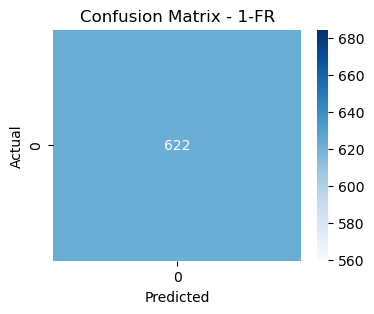

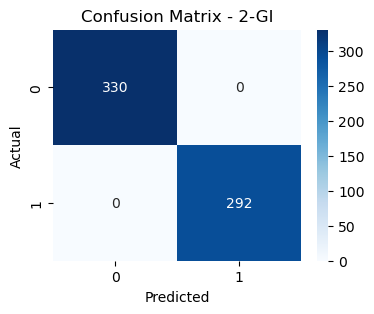

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


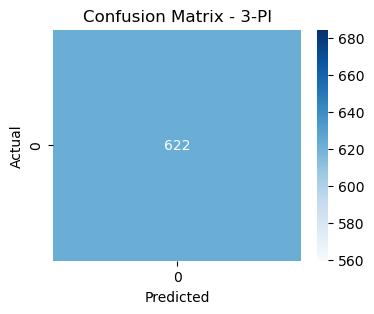

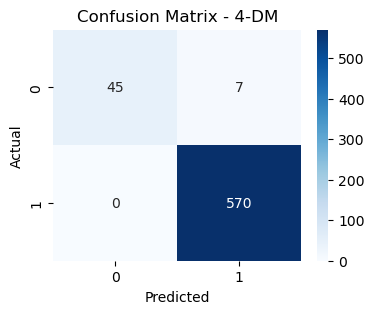

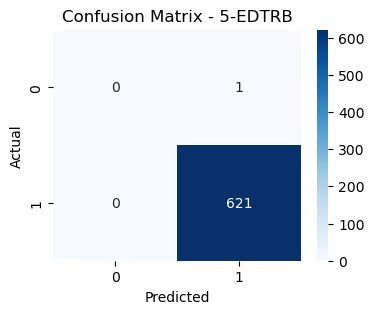

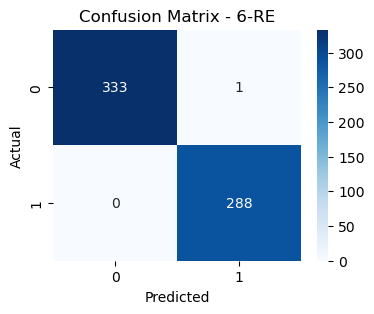

In [386]:
# --------------------------------------------------------------
# 7️⃣ Confusion Matrix per Label
# --------------------------------------------------------------

for i, label in enumerate(y_test.columns):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Confusion Matrix - {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [387]:
# --------------------------------------------------------------
# 8️⃣ FEATURE IMPORTANCE (Gain)
# --------------------------------------------------------------

print("\n🔥 XGBoost FEATURE IMPORTANCE (Gain)")

for i, label in enumerate(y_test.columns):
    model_i = best_xgb.estimators_[i]

    # Skip jika model bukan XGBoost
    if not hasattr(model_i, "get_booster"):
        print(f"\n⚠️ Label '{label}' dilewati (constant predictor / tidak dilatih).")
        continue

    booster = model_i.get_booster()
    importance_dict = booster.get_score(importance_type='gain')

    sorted_imp = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:10]

    print(f"\nTop Features for Label {label}:")
    for rank, (feat, score) in enumerate(sorted_imp, 1):
        print(f"{rank}. {feat} → gain={score:.4f}")



🔥 XGBoost FEATURE IMPORTANCE (Gain)

⚠️ Label '1-FR' dilewati (constant predictor / tidak dilatih).

Top Features for Label 2-GI:
1. f8075 → gain=467.9870
2. f6381 → gain=467.8367
3. f1902 → gain=400.3638
4. f8189 → gain=399.3486
5. f8151 → gain=348.8210
6. f8159 → gain=348.4892
7. f8022 → gain=346.6591
8. f8152 → gain=323.8728
9. f8004 → gain=319.9107
10. f8205 → gain=287.5506

⚠️ Label '3-PI' dilewati (constant predictor / tidak dilatih).

Top Features for Label 4-DM:
1. f8154 → gain=538.3478
2. f8028 → gain=337.4943
3. f4046 → gain=171.6519
4. f8193 → gain=134.9293
5. f8030 → gain=129.3575
6. f8057 → gain=114.2800
7. f8060 → gain=104.9596
8. f8096 → gain=94.0524
9. f8110 → gain=71.3695
10. f5286 → gain=68.8586

Top Features for Label 5-EDTRB:
1. f8157 → gain=26.4710
2. f1789 → gain=17.9929
3. f8130 → gain=12.8639
4. f8163 → gain=9.8399
5. f8091 → gain=9.4613
6. f8294 → gain=8.5245
7. f8226 → gain=8.3684
8. f8015 → gain=8.3564
9. f8164 → gain=7.5841
10. f8161 → gain=6.6372

Top Feat

In [388]:
# --------------------------------------------------------------
# Convert TRAIN sparse → dense DataFrame
# --------------------------------------------------------------
if issparse(X_train_combined):
    X_train_dense = pd.DataFrame(
        X_train_combined.toarray(),
        columns=[f"f_{i}" for i in range(X_train_combined.shape[1])]
    )
else:
    X_train_dense = pd.DataFrame(X_train_combined)

print("X_train_dense:", X_train_dense.shape)

X_train_dense: (2488, 8300)


In [389]:
# --------------------------------------------------------------
# 🔵 F1 — CROSS VALIDATION (k-Fold) — Per Label
# --------------------------------------------------------------

from sklearn.model_selection import KFold, cross_val_score

print("\n🔵 CROSS VALIDATION (k-Fold = 5)\n")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for i, label in enumerate(y_train.columns):

    estimator = best_xgb.estimators_[i]

    if estimator.__class__.__name__ == "_ConstantPredictor":
        print(f"⚠️ Label '{label}' dilewati (constant predictor)")
        cv_results[label] = None
        continue

    scores = cross_val_score(
        estimator,
        X_train_dense,
        y_train.iloc[:, i],
        cv=kf,
        scoring="f1"
    )

    cv_results[label] = scores

    print(f"Label {label}: Mean F1 = {scores.mean():.4f}  |  Std = {scores.std():.4f}")



🔵 CROSS VALIDATION (k-Fold = 5)

⚠️ Label '1-FR' dilewati (constant predictor)
Label 2-GI: Mean F1 = 0.9982  |  Std = 0.0027
⚠️ Label '3-PI' dilewati (constant predictor)
Label 4-DM: Mean F1 = 0.9913  |  Std = 0.0050
Label 5-EDTRB: Mean F1 = 0.9992  |  Std = 0.0008
Label 6-RE: Mean F1 = 0.9962  |  Std = 0.0041


In [390]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import joblib
import time
import os

# safety: pastikan variabel penting ada
assert 'best_xgb' in globals() or 'model_dict' in globals(), "best_xgb / model_dict tidak ditemukan"
assert 'X_train_combined' in globals(), "X_train_combined missing"
assert 'X_test_combined' in globals(), "X_test_combined missing"
assert 'y_train' in globals() and 'y_test' in globals(), "y_train / y_test missing"

# buat dense DataFrame (kalau belum dibuat)
from scipy.sparse import issparse
if issparse(X_train_combined):
    X_train_dense = pd.DataFrame(X_train_combined.toarray(),
                                 columns=[f"f_{i}" for i in range(X_train_combined.shape[1])])
else:
    X_train_dense = pd.DataFrame(X_train_combined)

if issparse(X_test_combined):
    X_test_dense = pd.DataFrame(X_test_combined.toarray(),
                                columns=[f"f_{i}" for i in range(X_test_combined.shape[1])])
else:
    X_test_dense = pd.DataFrame(X_test_combined)

print("X_train_dense:", X_train_dense.shape, "X_test_dense:", X_test_dense.shape)


X_train_dense: (2488, 8300) X_test_dense: (622, 8300)


In [391]:
# -------------------------------------------------------------
# SELECT TOP-K FEATURES FROM XGBOOST GAIN
# -------------------------------------------------------------

K = 300  # recommended, adjustable
top_features_per_label = {}

def safe_parse_feature_name(name):
    if isinstance(name, str):
        stripped = name.lstrip("f")
        if stripped.isdigit():
            return int(stripped)
    return None

print("Collecting top-K features from XGBoost gain (per label)...")

for i, label in enumerate(y_test.columns):

    # Select estimator
    try:
        est = best_xgb.estimators_[i]
    except:
        est = model_dict.get(label, None)

    if est is None or est.__class__.__name__ == "_ConstantPredictor":
        print(f"{label}: skipped — constant or missing model.")
        top_features_per_label[label] = []
        continue

    # Extract Gain importance
    booster = est.get_booster()
    gain = booster.get_score(importance_type="gain")

    sorted_gain = sorted(gain.items(), key=lambda x: x[1], reverse=True)

    raw_feats = [feat_name for feat_name, _ in sorted_gain[:K]]

    parsed_feats = []
    for f in raw_feats:
        idx = safe_parse_feature_name(f)
        if idx is not None and 0 <= idx < X_train_dense.shape[1]:
            parsed_feats.append(idx)

    top_features_per_label[label] = parsed_feats

    print(f"{label}: {len(parsed_feats)} top features selected ✔️")

1-FR: skipped — constant or missing model.
2-GI: 292 top features selected ✔️
3-PI: skipped — constant or missing model.
4-DM: 300 top features selected ✔️
5-EDTRB: 39 top features selected ✔️
6-RE: 150 top features selected ✔️


In [392]:
# union all selected features (unique)
union_features = sorted(set().union(*[set(v) for v in top_features_per_label.values() if v]))
print("Union features count:", len(union_features))

# jika union terlalu besar, potong ke top global K_total
K_total = 500
if len(union_features) > K_total:
    union_features = union_features[:K_total]
    print("Trimmed union_features to", K_total)

# buat kolom names
col_names = [f"f_{i}" for i in union_features]

X_test_small = X_test_dense.iloc[:, union_features].copy().reset_index(drop=True)
X_train_small = X_train_dense.iloc[:, union_features].copy().reset_index(drop=True)

print("X_train_small:", X_train_small.shape, "X_test_small:", X_test_small.shape)


Union features count: 489
X_train_small: (2488, 489) X_test_small: (622, 489)


In [393]:
print("\n=== Permutation Importance (Filtered Features) ===")

perm_results = {}

unique_labels = y_test.columns.tolist()  # FIX

for label in unique_labels:
    print(f"\nLabel: {label}")
    if label not in models or model_dict[label] is None:
        print(f"⚠️  Skipped — no trained model for label {label}")
        perm_results[label] = None
        continue
    
    estimator = model_dict[label]

    # Build dataframe with correct feature names
    X_perm = pd.DataFrame(X_test_small, columns=[f"f{i}" for i in range(X_test_small.shape[1])])

    # Validation check
    model_features = estimator.get_booster().feature_names
    if set(model_features) != set(X_perm.columns):
        print("⚠ MISMATCH — estimator trained features vs provided features")
        print("Model features sample:", model_features[:5])
        print("Input features sample:", list(X_perm.columns[:5]))
        continue

    # Run permutation importance
    r = permutation_importance(
        estimator=estimator,
        X=X_perm,
        y=y_test[label].values,
        n_repeats=10,
        random_state=42,
        scoring="f1",
        n_jobs=-1
    )

    perm_results[label] = r
    print("Mean F1 drop:", np.mean(r.importances_mean))



=== Permutation Importance (Filtered Features) ===

Label: 1-FR
⚠️  Skipped — no trained model for label 1-FR

Label: 2-GI
⚠️  Skipped — no trained model for label 2-GI

Label: 3-PI
⚠️  Skipped — no trained model for label 3-PI

Label: 4-DM
⚠️  Skipped — no trained model for label 4-DM

Label: 5-EDTRB
⚠️  Skipped — no trained model for label 5-EDTRB

Label: 6-RE
⚠️  Skipped — no trained model for label 6-RE


In [394]:
# summary plots
for label, df in perm_results.items():
    if df is None:
        continue

    plt.figure(figsize=(8,5))
    sns.barplot(
        x="importance_mean",
        y="feature_name",
        data=df.head(15)
    )
    plt.title(f"Permutation Importance — {label} (top 15)")
    plt.xlabel("Mean importance (drop in F1)")
    plt.tight_layout()
    plt.savefig(f"{RESULT_DIR}/perm_top15_{label}.png", dpi=150)
    plt.show()


In [395]:
consistency = {}

for i, label in enumerate(y_test.columns):

    # Skip if no permutation computed
    if label not in perm_results or perm_results[label] is None:
        print(f"{label}: skipped (no perm result)")
        continue

    # Top 20 from permutation importance DataFrame
    perm_df = perm_results[label]
    top_perm = perm_df["feature"].head(20).tolist()

    # Top 20 from XGBoost Gain
    try:
        est = best_xgb.estimators_[i]
        gain_dict = est.get_booster().get_score(importance_type='gain')
        sorted_gain = sorted(gain_dict.items(), key=lambda x: x[1], reverse=True)
        top_gain = [int(f[0].lstrip("f")) for f in sorted_gain[:20]]
    except:
        top_gain = []

    # Compute overlap
    overlap = set(top_gain).intersection(set(top_perm))
    consistency[label] = {
        "top_gain_20": top_gain,
        "top_perm_20": top_perm,
        "overlap_count": len(overlap),
        "overlap_features": list(overlap)
    }

    print(f"{label}: overlap {len(overlap)} / 20")

1-FR: skipped (no perm result)
2-GI: skipped (no perm result)
3-PI: skipped (no perm result)
4-DM: skipped (no perm result)
5-EDTRB: skipped (no perm result)
6-RE: skipped (no perm result)


In [396]:
import os
import json

# Folder tujuan
RESULT_DIR = "results"
os.makedirs(RESULT_DIR, exist_ok=True)

# Simpan file JSON
with open(f"{RESULT_DIR}/perm_consistency.json", "w") as f:
    json.dump(consistency, f, indent=2)

print("File saved to:", f"{RESULT_DIR}/perm_consistency.json")

File saved to: results/perm_consistency.json


In [397]:
os.makedirs("model_artifacts", exist_ok=True)

# Save vectorizer & scaler
joblib.dump(vectorizer, "model_artifacts/vectorizer_tfidf.pkl")
joblib.dump(scaler, "model_artifacts/scaler_embed.pkl")

# Save per-label models (XGBoost raw)
for i, label in enumerate(y_test.columns):
    try:
        est = model_dict[label] if 'model_dict' in globals() else best_xgb.estimators_[i]
        if est is None or est.__class__.__name__ == "_ConstantPredictor":
            continue
        joblib.dump(est, f"model_artifacts/xgb_{label}.pkl")
    except Exception as e:
        print("Save model error for", label, e)

# Save union features
pd.DataFrame({"feature_idx": union_features, "feature_name":[f"f_{j}" for j in union_features]}).to_csv(
    "model_artifacts/selected_features_union.csv", index=False
)

print("Artifacts saved in model_artifacts/")


Artifacts saved in model_artifacts/


In [ ]:
# ==============================================================
# STEP F — IMPLEMENTASI AI SCREENING FUNCTION (FIXED & OPTIMIZED)
# ==============================================================

import joblib
import numpy as np
import re
from nltk.tokenize import word_tokenize
from scipy.sparse import csr_matrix, hstack
import pandas as pd
import gensim

# 1. LOAD ARTIFACTS
print("Loading model artifacts...")
vectorizer = joblib.load("model_artifacts/vectorizer_tfidf.pkl")
scaler = joblib.load("model_artifacts/scaler_embed.pkl") # Scaler untuk embedding

# Labels
label_cols = ['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE']

# 2. LOAD MODELS
models = {}
model_feature_counts = {} 

for label in label_cols:
    try:
        model = joblib.load(f"model_artifacts/xgb_{label}.pkl")
        models[label] = model
        # Simpan jumlah fitur yang diharapkan oleh model
        model_feature_counts[label] = model.get_booster().num_features()
    except:
        # Jika model tidak ditemukan (kasus Constant Predictor)
        print(f"⚠️ Model untuk {label} tidak ditemukan/error. Default probability diset ke 1.0")
        models[label] = None
        model_feature_counts[label] = 0

# 3. LOAD FEATURE SELECTION
sel_df = pd.read_csv("model_artifacts/selected_features_union.csv")
union_features = sel_df["feature_idx"].tolist()

# 4. LOAD FASTTEXT (Pastikan path file .bin benar)
print("Loading FastText (ini mungkin memakan waktu)...")
fasttext_path = "/Users/farrel01/Documents/fasttext/cc.id.300.bin" # Sesuaikan path
try:
    fasttext_model = gensim.models.FastText.load_fasttext_format(fasttext_path)
    print("FastText loaded successfully.")
except Exception as e:
    print(f"ERROR Loading FastText: {e}")
    # Fallback dummy jika gagal load (agar code tidak crash saat testing struktur)
    fasttext_model = None 

def get_sentence_vector(text):
    if fasttext_model is None: return np.zeros(300, dtype=np.float32)
    
    tokens = word_tokenize(str(text).lower())
    vectors = [fasttext_model.wv[w] for w in tokens if w in fasttext_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300, dtype=np.float32)

def ai_screening(text):
    """Return dictionary: label : probability"""
    
    # A. TF-IDF Transform
    tfidf_vec = vectorizer.transform([text]) # Hasilnya sparse matrix

    # B. FastText Embedding
    embed = get_sentence_vector(text).reshape(1, -1)
    
    # FIX: Gunakan Scaler yang sudah di-load!
    # Saat training, embedding di-scale. Saat prediksi juga wajib di-scale.
    embed_scaled = scaler.transform(embed) 
    embed_sparse = csr_matrix(embed_scaled)

    # C. Gabungkan (Stacking)
    # Ini adalah X lengkap (Full Features) sebelum seleksi
    X_full = hstack([tfidf_vec, embed_sparse])

    # D. Feature Selection (Union)
    # Ambil hanya kolom-kolom yang terdaftar di union_features
    # Kita perlu memastikan index tidak out of bound
    try:
        X_fs = X_full[:, union_features]
    except IndexError:
        # Jaga-jaga jika dimensi TFIDF berubah (jarang terjadi jika pkl sama)
        print("Warning: Index mismatch pada feature selection.")
        X_fs = X_full

    results = {}

    for label in label_cols:
        model = models[label]

        # HANDLER UNTUK MODEL NONE (1-FR & 3-PI)
        if model is None:
            # Karena di data training 1-FR dan 3-PI muncul 100% (nilai 1),
            # maka logisnya probabilitasnya adalah 1.0 (pasti ada), bukan 0.
            results[label] = 1.000 
            continue

        # E. Dimension Check (Safety)
        # XGBoost kadang rewel jika nama kolom/jumlah kolom beda sedikit
        needed = model_feature_counts[label]
        current_features = X_fs.shape[1]
        
        X_final = X_fs

        if current_features < needed:
            # Padding jika kurang (tambah kolom 0)
            pad = np.zeros((X_fs.shape[0], needed - current_features))
            X_final = hstack([X_fs, csr_matrix(pad)])
        elif current_features > needed:
            # Trimming jika kelebihan
            X_final = X_fs[:, :needed]

        # Prediksi
        # X_final masih sparse matrix, XGBoost bisa baca sparse secara efisien
        proba = model.predict_proba(X_final)[0][1]
        results[label] = float(proba)

    return results

# ==========================
# TESTING LOOP
# ==========================
print("\n=== AI READY TO SERVE ===")
while True:
    user_input = input("\nMasukkan keluhan pasien (or 'exit'): ")
    if user_input.lower() == "exit":
        break

    if not user_input.strip():
        continue

    try:
        res = ai_screening(user_input)
        
        print("\n--- RESULT AI SCREENING ---")
        for k, v in res.items():
            # Format output persen agar lebih mudah dibaca
            bar = "█" * int(v * 10)
            print(f"{k.ljust(8)} : {v:.4f}  {bar}")
        print("---------------------------")
    except Exception as e:
        print(f"Error processing input: {e}")

Loading model artifacts...
⚠️ Model untuk 1-FR tidak ditemukan/error. Default probability diset ke 1.0
⚠️ Model untuk 3-PI tidak ditemukan/error. Default probability diset ke 1.0
Loading FastText (ini mungkin memakan waktu)...


/var/folders/jr/bnpd2zjx6dg94lplg1mppz100000gn/T/ipykernel_17686/3228729648.py:45: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_model = gensim.models.FastText.load_fasttext_format(fasttext_path)


In [432]:
print("TFIDF vocabulary size:", len(vectorizer.vocabulary_))
print("Max selected index:", max(union_features))
print("Model feature count:", model_feature_counts)

TFIDF vocabulary size: 8000
Max selected index: 8299
Model feature count: {'1-FR': None, '2-GI': 8300, '3-PI': None, '4-DM': 8300, '5-EDTRB': 8300, '6-RE': 8300}


In [436]:
!jupyter nbconvert --to html Klasifikasi_Jawaban_Dokter_dalam_Konsultasi_Kesehatan_Online_Menggunakan_Machine_Learning.ipynb

[NbConvertApp] Converting notebook Klasifikasi_Jawaban_Dokter_dalam_Konsultasi_Kesehatan_Online_Menggunakan_Machine_Learning.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 566881 bytes to Klasifikasi_Jawaban_Dokter_dalam_Konsultasi_Kesehatan_Online_Menggunakan_Machine_Learning.html
